# 0. Load Setups

In [1]:
# Load modules
import cfd_simulate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import three_desc_model as exponential_new
from itertools import combinations
from cutoffs import Polynomial
import GP_functions1 as GP
from GP_functions1 import TurbineUtility
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

In [10]:
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import KFold

In [3]:

import GPy
from IPython.display import display
GPy.plotting.change_plotting_library('matplotlib')

In [4]:
#Set up neighbourlist calculation
# USE NEW CLASSES
turbine_utility = TurbineUtility()
nl = turbine_utility.nl
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
symbol="Siemens"
turb = [symbol]

In [5]:
# Constants
min_dist = 279.0
max_xdist = 4000
max_width = 500
numturb = 4

In [6]:
min_threshold = 4 # Valid numbers
max_threshold = 25

In [7]:
def calculate_power_output(refwind, min_threshold, max_threshold):
    total_power = np.sum(refwind)
    individual_scores = np.where((refwind >= min_threshold) & (refwind <= max_threshold), refwind, 0)
    fitness = total_power + np.sum(individual_scores)
    return fitness

# 1. Original Model

## Load Data

In [8]:
dataset_full = pd.read_csv('all_dataset.csv', index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_630389/3090405090.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [20]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

## Train Model

### Original

In [21]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [28]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [29]:
m.optimize(messages=True,max_f_eval = 1000)


## Model Uncertianty Demonstration

In [24]:
[Ypred,Yvar]=m.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
print('Test error: ',np.max(error_test))

Test error:  0.361691268950878


In [25]:
[Yval,Yvalvar]=m.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
print('Train error: ',np.max(error_train))

Train error:  0.42396954072056303


In [26]:
[Yall,Yallvar]=m.predict(X)
error_all=np.abs(Yall-Y)
print('Overall error: ',np.max(error_all))

Overall error:  0.42396954072056303


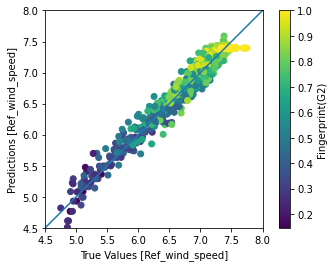

In [27]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

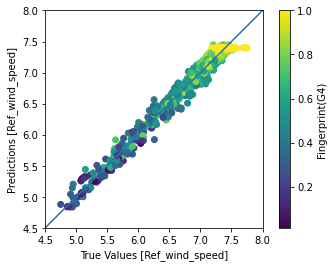

In [17]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [18]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

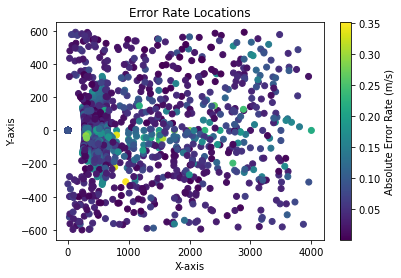

In [19]:
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all) # Result gives worse with added data
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [20]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

In [21]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

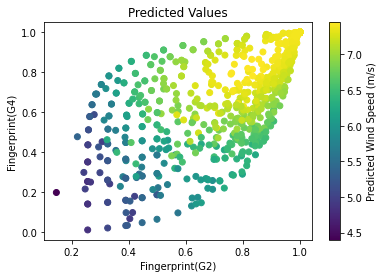

In [22]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

In [23]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

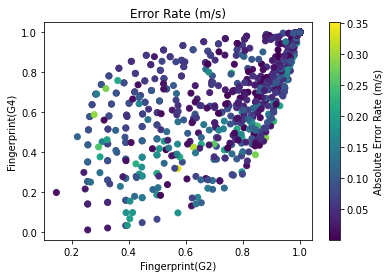

In [24]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

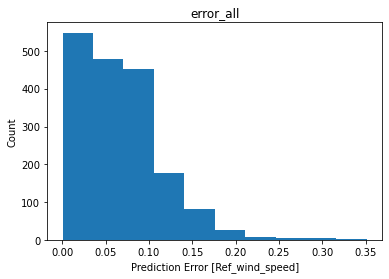

In [25]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]') # Really different error rates, one more spread, one more concentrate
plt.title('error_all')
_ = plt.ylabel('Count')

In [26]:
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')

# 2. Particle Swarm Optimisation model

In [110]:
dataset_full = pd.read_csv('all_dataset_ga.csv')
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


 /tmp/ipykernel_170316/853801795.py:5: FutureWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [74]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [75]:
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [76]:
# m = GPy.models.SparseGPRegression(Xtrain,Ytrain,ker)
m_pso = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [77]:
m_pso.optimize(messages=True,max_f_eval = 1000)


In [78]:
min_dist = 279.0
bounds = [(0, 0), (4000, 500)] # 0,0 as initial, 4000,500 as field
pop_size=30
max_iter=100
inertia=0.8
cognitive=1.5
social=1.5


In [79]:
def fitness_function(turbines, min_dist):
    numturb = turbines.shape[0]
    distances = pairwise_distances(turbines)
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances
    
    if np.any(distances < min_dist):
        return -np.inf  # Penalize solutions with close turbines
    
    neigh = nl.calculate(['Siemens'] * numturb, turbines)
    fingerprints = np.array(finpr.calculate(['Siemens'] * numturb, turbines, neigh, 'Siemens'))
    _, refstdev = m_pso.predict(fingerprints)
    total_uncertainty = np.sum(refstdev)
    return total_uncertainty

# Initialize particles and velocities
def initialize_particles(pop_size, num_turb, bounds):
    particles = np.random.uniform(bounds[0], bounds[1], (pop_size, num_turb, 2))
    particles[:, 0, :] = [0, 0]  # Fix the first turbine at (0, 0)
    velocities = np.random.uniform(-1, 1, (pop_size, num_turb, 2))
    return particles, velocities

# Update velocity of a particle
def update_velocity(particle, velocity, personal_best, global_best, inertia, cognitive, social):
    r1, r2 = np.random.rand(), np.random.rand()
    new_velocity = (
        inertia * velocity +
        cognitive * r1 * (personal_best - particle) +
        social * r2 * (global_best - particle)
    )
    return new_velocity

# Update position of a particle
def update_position(particle, velocity, bounds):
    new_position = particle + velocity
    new_position = np.clip(new_position, bounds[0], bounds[1])
    new_position[0] = [0, 0]  # Ensure the first turbine stays fixed at (0, 0)
    return new_position

# Particle Swarm Optimisation (PSO) algorithm
def pso(bounds, min_dist, num_turb, pop_size, max_iter, inertia, cognitive, social):
    particles, velocities = initialize_particles(pop_size, num_turb, bounds)
    personal_bests = particles.copy()
    personal_best_fitnesses = np.array([fitness_function(p, min_dist) for p in particles])
    global_best = particles[np.argmax(personal_best_fitnesses)]
    global_best_fitness = np.max(personal_best_fitnesses)
    
    for iteration in range(max_iter):
        for i in range(pop_size):
            fitness = fitness_function(particles[i], min_dist)
            if fitness > personal_best_fitnesses[i]:
                personal_bests[i] = particles[i]
                personal_best_fitnesses[i] = fitness
                
                if fitness > global_best_fitness:
                    global_best = particles[i]
                    global_best_fitness = fitness
        
        for i in range(pop_size):
            velocities[i] = update_velocity(particles[i], velocities[i], personal_bests[i], global_best, inertia, cognitive, social)
            particles[i] = update_position(particles[i], velocities[i], bounds)
        
        print(f"Iteration {iteration}: Max Uncertainty = {global_best_fitness}")
    
    return global_best

In [108]:
locpso = pso(bounds, min_dist, 5, pop_size, max_iter, inertia, cognitive, social)

print("Optimised Turbine Locations:", locpso)

Generation 0
Best fitness: 0.10962540978158947
Generation 1
Best fitness: 0.10962540978158947
Generation 2
Best fitness: 0.11324632714326914
Generation 3
Best fitness: 0.11324632714326914
Generation 4
Best fitness: 0.11324632714326914
Generation 5
Best fitness: 0.13798182655124874
Generation 6
Best fitness: 0.13798182655124874
Generation 7
Best fitness: 0.13798182655124874
Generation 8
Best fitness: 0.13798182655124874
Generation 9
Best fitness: 0.13798182655124874
Generation 10
Best fitness: 0.13798182655124874
Generation 11
Best fitness: 0.13798182655124874
Generation 12
Best fitness: 0.13798182655124874
Generation 13
Best fitness: 0.13798182655124874
Generation 14
Best fitness: 0.1559970232115369
Generation 15
Best fitness: 0.1559970232115369
Generation 16
Best fitness: 0.1559970232115369
Generation 17
Best fitness: 0.17946044615626638
Generation 18
Best fitness: 0.17946044615626638
Generation 19
Best fitness: 0.17946044615626638
Generation 20
Best fitness: 0.17946044615626638
Gener

In [111]:
numturb = 5
# data = [[   0.,            0.        ],
#  [ 194.04045497,  287.87936105],
#  [2036.38375936,  148.47537671],
#  [ 320.33352912,   10.34616954]]
# data = [[  0.,           0.        ],
#  [625.26204523, 202.54367876],
#  [390.38093941,  51.95458178],
#  [897.30078212, 140.60882887]]
# locpso = np.array(data)
neighpso=nl.calculate(turb*numturb,locpso)
fingerprints=np.array(finpr.calculate(turb*numturb,locpso,neighpso,symbol))
print(fingerprints)
refwindpso,refstdevpso=m_pso.predict(fingerprints)

[[1.         1.         1.        ]
 [0.3493497  0.01169256 0.0114662 ]
 [0.22598914 0.21798855 0.27913967]
 [0.99670403 0.99886553 1.        ]
 [0.33417607 0.02826851 0.03061816]]


In [112]:
print('Optimised Power Output: ', calculate_power_output(refwindpso, min_threshold, max_threshold))
print('Optimised Uncertainty: ', refstdevpso)
print('Optimised Total Uncertainty: ', np.sum(refstdevpso))

print('Optimised Wind Speed: ', refwindpso)


Optimised Power Output:  58.32141742061603
Optimised Uncertainty:  [[0.0073338 ]
 [0.10457995]
 [0.00977659]
 [0.0073341 ]
 [0.07615907]]
Optimised Total Uncertainty:  0.2051835151009858
Optimised Wind Speed:  [[7.39674941]
 [4.78198915]
 [4.76189648]
 [7.39642759]
 [4.82364608]]


In [113]:
numturb = locpso.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(locpso[i,0], locpso[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(locpso[i, 0], locpso[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


## Model Uncertainty Demonstration

In [80]:
[Ypred,Yvar]=m_pso.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.max(error_test)

0.3908079975362835

In [81]:
[Yval,Yvalvar]=m_pso.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.max(error_train)

0.44716532468607717

In [82]:
[Yall,Yallvar]=m_pso.predict(X)
error_all=np.abs(Yall-Y)
np.max(error_all)

0.44716532468607717

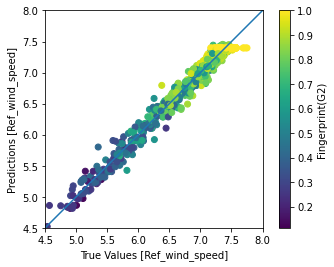

In [83]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [84]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [85]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [86]:
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all) # Result gives worse with added data
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

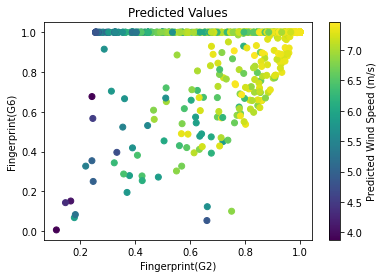

In [87]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

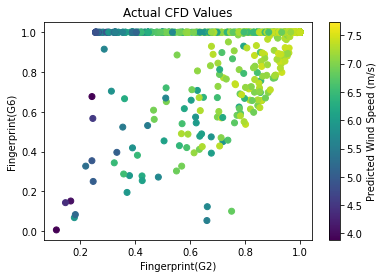

In [88]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,2],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,2],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G6)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

In [89]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

In [90]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

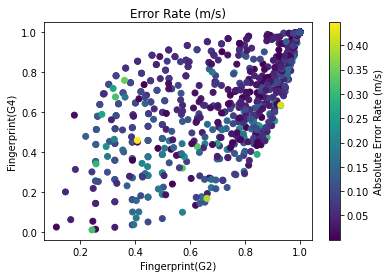

In [91]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

<IPython.core.display.Javascript object>


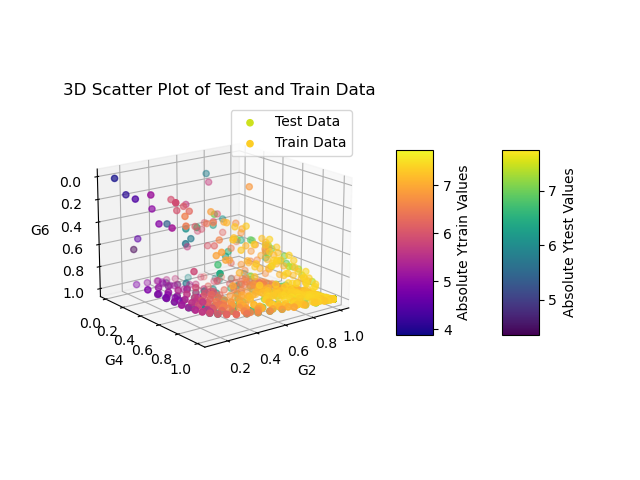

In [131]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the test data
sc1 = ax.scatter(Xtest[:, 0], Xtest[:, 1], Xtest[:, 2], c=np.abs(Ytest), cmap='viridis', label='Test Data')

# Plot the train data
sc2 = ax.scatter(Xtrain[:, 0], Xtrain[:, 1], Xtrain[:, 2], c=np.abs(Ytrain), cmap='plasma', label='Train Data')

# Add color bars
cbar1 = plt.colorbar(sc1, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar1.set_label('Absolute Ytest Values')
cbar2 = plt.colorbar(sc2, ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar2.set_label('Absolute Ytrain Values')

ax.set_xlabel('G2')
ax.set_ylabel('G4')
ax.set_zlabel('G6')
ax.set_title('3D Scatter Plot of Test and Train Data')


ax.legend()

plt.show()

3d plot

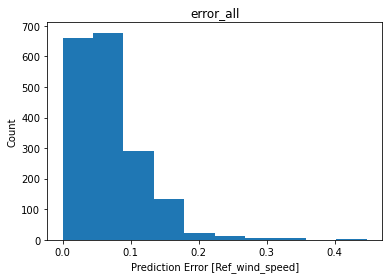

In [92]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]') # Really different error rates, one more spread, one more concentrate
plt.title('error_all')
_ = plt.ylabel('Count')

In [93]:
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')

# 3. Model uncertainty comparison

In [52]:

data = [[   0.,            0.        ],
 [ 660.20929559,  166.08307548],
 [ 999.68269048,  164.25800406],
 [1323.15500511,  173.21673579]]

locpso = np.array(data)

Optimised Power Output:  39.4523212002165

Optimised Uncertainty:  [[0.00669342]
 [0.00669342]
 [0.25305178]
 [1.37515895]]
 
Optimised Total Uncertainty:  1.6415975723219607

Optimised Wind Speed:  [[7.39772673]
 [7.39772673]
 [4.87991199]
 [4.9815023 ]]

In [118]:
fixed_turbine_positions = [
    (0, 0),
    (660.20929559,  166.08307548),
    (999.68269048,  164.25800406)
]


In [119]:
symbol = "Siemens"
turb = [symbol] * 4 
nl = exponential_new.NeighborlistCalculator(cutoff=4001, cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr = exponential_new.FingerprintCalculator(
    cutoff=4001, 
    Gs=Gs,
    Rct=3000,
    delta_R=100,
    cone_grad=0.12582561117875557,
    cone_offset=72.24947126849844
)

In [120]:
num_candidates = 10000
candidate_positions = np.zeros((num_candidates, 2))

for i in range(num_candidates):
    while True:
        candidate = np.array([
            np.random.uniform(-300, 4500),
            np.random.uniform(-500, 500)
        ])
        distances = [np.linalg.norm(candidate - np.array(pos)) for pos in fixed_turbine_positions]
        if all(dist > min_dist for dist in distances):
            candidate_positions[i] = candidate
            break


In [121]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m.predict(fingerprints)
    
    uncertainties[idx] = refstdev[3]  # Uncertainty for the fourth turbine

In [122]:
max_uncertainty_idx = np.argmax(uncertainties)
max_uncertainty_pos = candidate_positions[max_uncertainty_idx]
print('Max Uncertainty point locates at: ',max_uncertainty_pos)

Max Uncertainty point locates at:  [1488.21507346  164.27465506]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


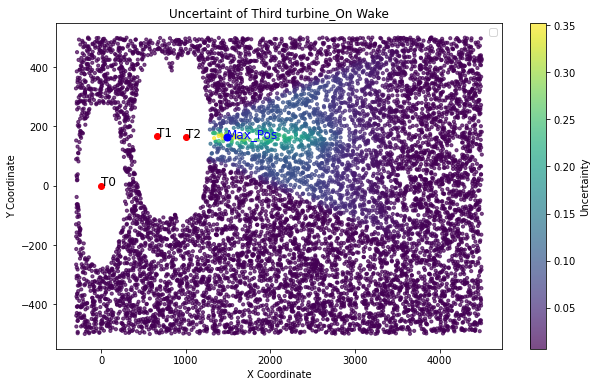

In [123]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

# Plot fixed turbine positions
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

# Labeling fixed turbines
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)
    
plt.scatter(max_uncertainty_pos[0], max_uncertainty_pos[1], color='blue', s=50)
plt.text(max_uncertainty_pos[0], max_uncertainty_pos[1], 'Max_Pos', fontsize=12, color='blue')


plt.title('Uncertaint of Third turbine_On Wake')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

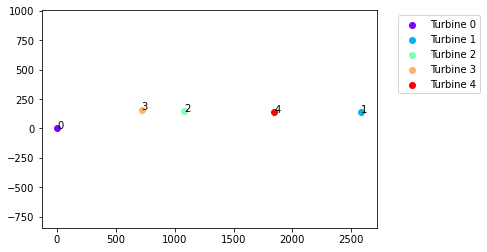

In [124]:
numturb = locpso.shape[0]

cmap = plt.get_cmap('rainbow', numturb)

for i in range(numturb):
    plt.scatter(locpso[i,0], locpso[i,1], color=cmap(i), label='Turbine ' + str(i))

# Set the desired limits for the x and yaxes
plt.xlim(-300, 4500)
plt.ylim(-500, 500)
plt.axis('equal')

# Add labels to each point
for i in range(numturb):
    plt.text(locpso[i, 0], locpso[i, 1], str(i))

# Add legends
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### Genetic Algorithm Model

In [125]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m_pso.predict(fingerprints)
    
    uncertainties[idx] = refstdev[3]  # Uncertainty for the fourth turbine

In [126]:
max_uncertainty_idx = np.argmax(uncertainties)
max_uncertainty_pos = candidate_positions[max_uncertainty_idx]
print('Max Uncertainty point locates at: ',max_uncertainty_pos)

Max Uncertainty point locates at:  [1967.89351888  161.64739968]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


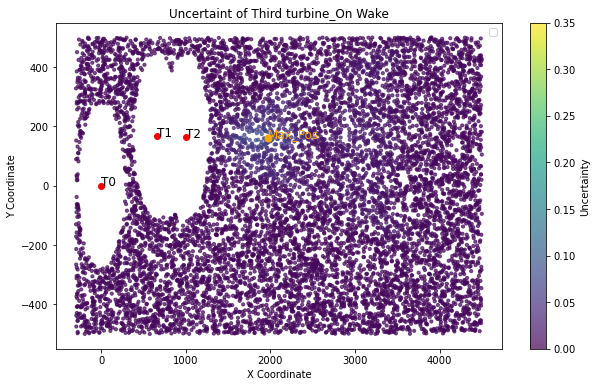

In [127]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', vmin=vmin, vmax=vmax, s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

# Plot fixed turbine positions
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

# Labeling fixed turbines
for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)
    
plt.scatter(max_uncertainty_pos[0], max_uncertainty_pos[1], color='orange', s=50)
plt.text(max_uncertainty_pos[0], max_uncertainty_pos[1], 'Max_Pos', fontsize=12, color='orange')

plt.title('Uncertaint of Third turbine_On Wake')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

## 5 Turbine

In [63]:

data = [[   0.,            0.        ],
 [1449.81690215,  204.15442664],
 [1870.55225293,  379.75098377],
 [2143.26148684,  320.27710446],
 [2478.8731692,   320.24930931]
 ]

locpso = np.array(data)

In [95]:
fixed_turbine_positions = [
    (0, 0),
    (1449.81690215,  204.15442664),
    (1870.55225293,  379.75098377),
    (2143.26148684,  320.27710446)
    
]


In [96]:
symbol = "Siemens"
turb = [symbol] * 5
nl = exponential_new.NeighborlistCalculator(cutoff=4001, cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr = exponential_new.FingerprintCalculator(
    cutoff=4001, 
    Gs=Gs,
    Rct=3000,
    delta_R=100,
    cone_grad=0.12582561117875557,
    cone_offset=72.24947126849844
)

In [97]:
num_candidates = 10000
candidate_positions = np.zeros((num_candidates, 2))

for i in range(num_candidates):
    while True:
        candidate = np.array([
            np.random.uniform(-300, 4500),
            np.random.uniform(-500, 500)
        ])
        distances = [np.linalg.norm(candidate - np.array(pos)) for pos in fixed_turbine_positions]
        if all(dist > min_dist for dist in distances):
            candidate_positions[i] = candidate
            break


In [98]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m.predict(fingerprints)
    
    uncertainties[idx] = refstdev[4]  # Uncertainty for the fourth turbine

In [99]:
max_uncertainty_idx = np.argmax(uncertainties)
max_uncertainty_pos = candidate_positions[max_uncertainty_idx]
print('Max Uncertainty point locates at: ',max_uncertainty_pos)

Max Uncertainty point locates at:  [2447.45810455  321.4497731 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


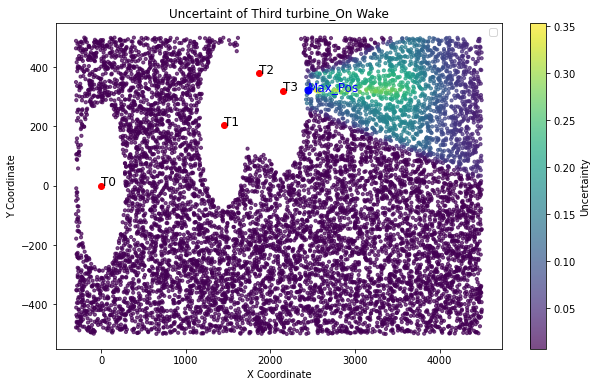

In [100]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)
    
plt.scatter(max_uncertainty_pos[0], max_uncertainty_pos[1], color='blue', s=50)
plt.text(max_uncertainty_pos[0], max_uncertainty_pos[1], 'Max_Pos', fontsize=12, color='blue')

plt.title('Uncertaint of Third turbine_On Wake')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()

### PSO 5 Turbine

In [101]:
uncertainties = np.zeros(num_candidates)

for idx, point in enumerate(candidate_positions):
    turbines = np.array(fixed_turbine_positions + [tuple(point)])
    neigh = nl.calculate(turb, turbines)
    fingerprints = np.array(finpr.calculate(turb, turbines, neigh, symbol))
    refwind, refstdev = m_pso.predict(fingerprints)
    
    uncertainties[idx] = refstdev[4]  # Uncertainty for the fourth turbine

In [102]:
max_uncertainty_idx = np.argmax(uncertainties)
max_uncertainty_pos = candidate_positions[max_uncertainty_idx]
print('Max Uncertainty point locates at: ',max_uncertainty_pos)

Max Uncertainty point locates at:  [3135.98081413  321.43513104]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


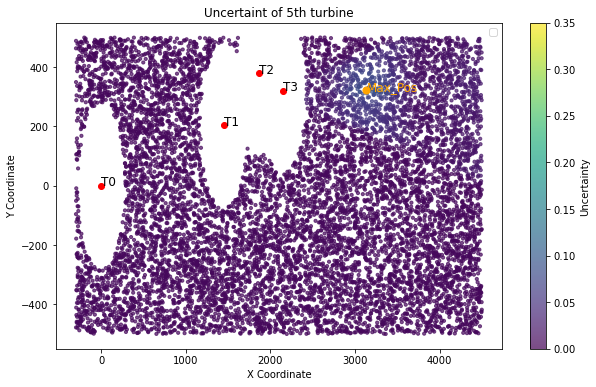

In [114]:
vmin = 0
vmax = 0.35
plt.figure(figsize=(10, 6))
sc = plt.scatter(candidate_positions[:, 0], candidate_positions[:, 1], c=uncertainties, cmap='viridis', vmin=vmin, vmax=vmax, s=10, alpha=0.7)
plt.colorbar(sc, label='Uncertainty')

for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.scatter(x, y, color='red')

for i, (x, y) in enumerate(fixed_turbine_positions):
    plt.text(x, y, f'T{i}', fontsize=12)
    
plt.scatter(max_uncertainty_pos[0], max_uncertainty_pos[1], color='Orange', s=50)
plt.text(max_uncertainty_pos[0], max_uncertainty_pos[1], 'Max_Pos', fontsize=12, color='Orange')

plt.title('Uncertaint of 5th turbine')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()